C:\Users\gonza\AppData\Local\Temp\ipykernel_34880\2721395054.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['duration_seconds'].replace(0, median_duration, inplace=True)


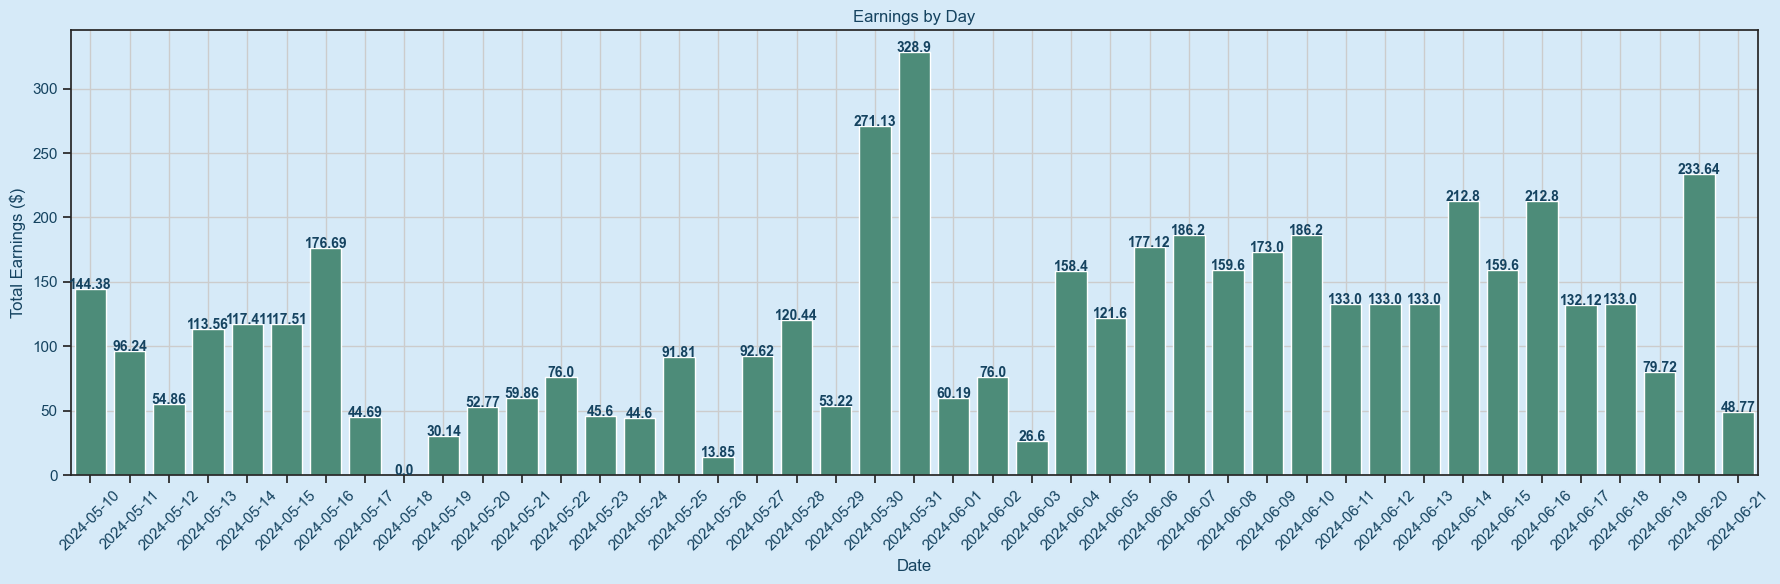

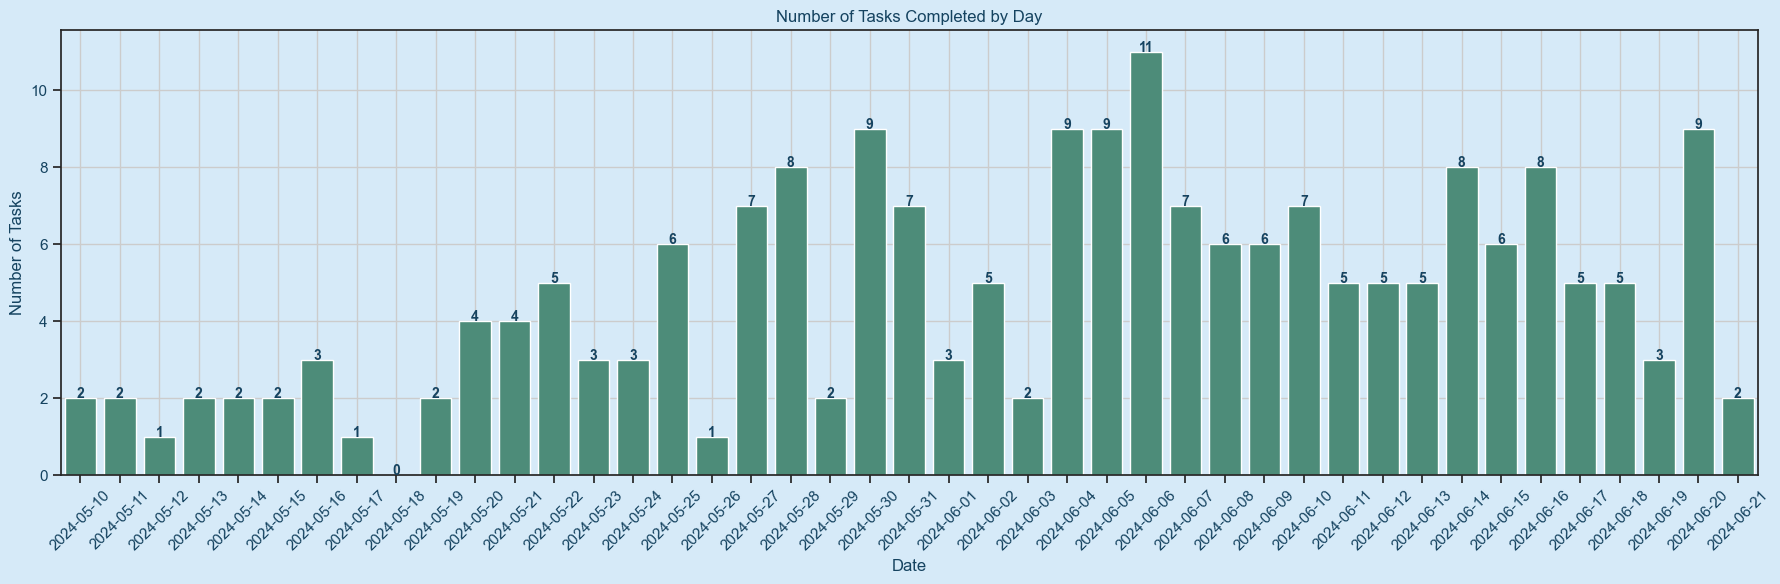

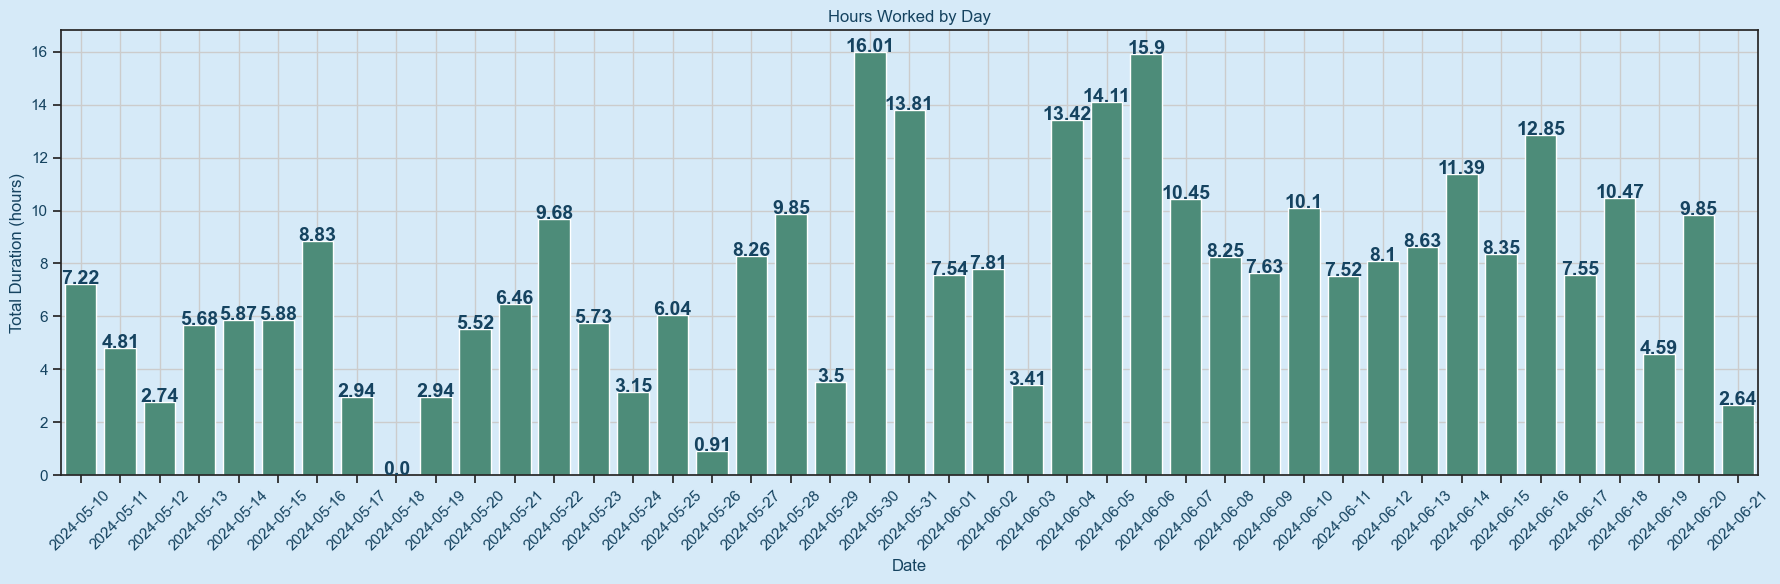

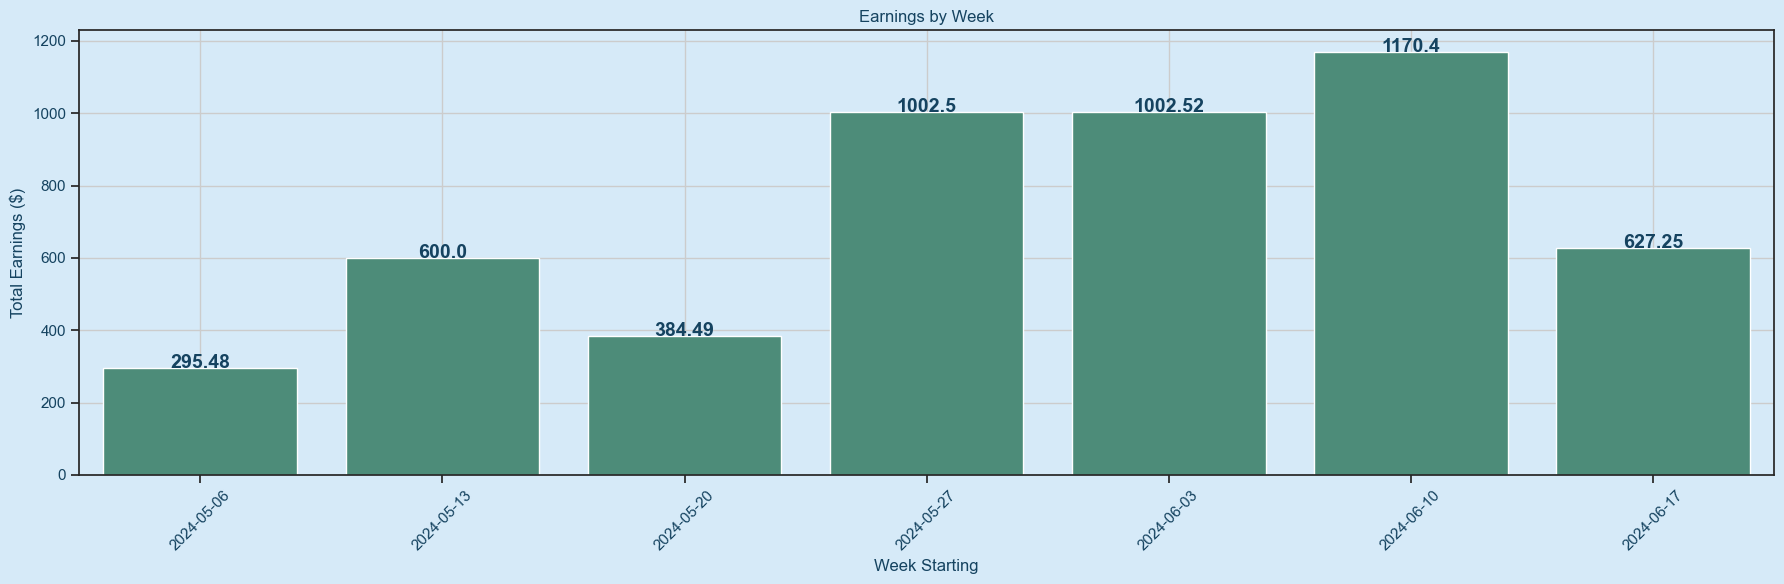

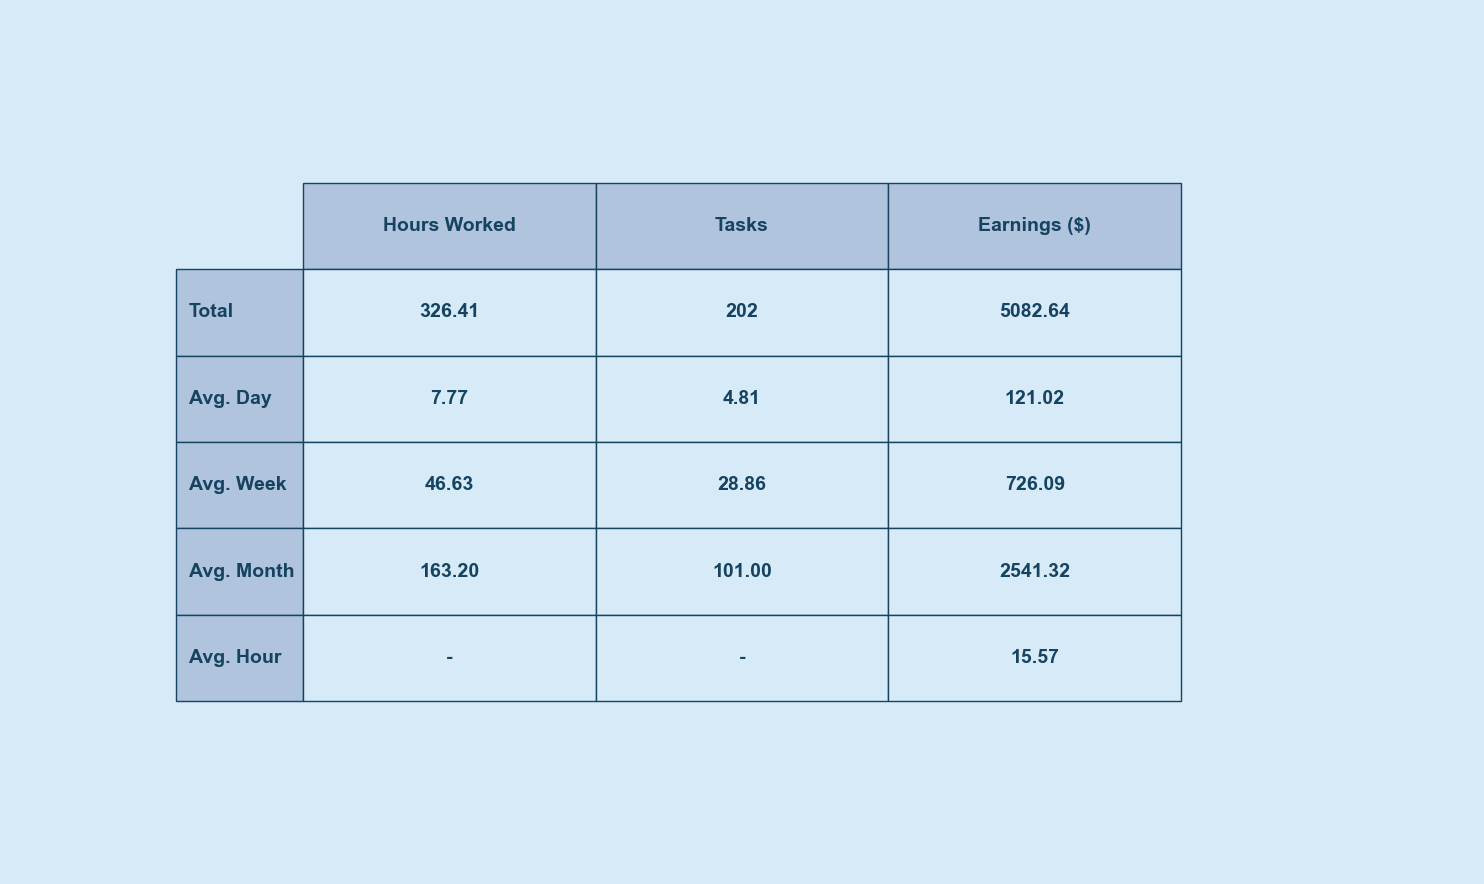

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set the Seaborn theme for better visual appearance
sns.set_theme(style="ticks")

# Customizing the plot background color
background_color = "#d6eaf8"  
text_color = "#154360"  
numbers_color = "#154360" 

# Path to the folder containing earnings data files
folder_path = 'pay-periods'
output_file = 'combined_earnings.csv'

# Combine all CSV files into a single DataFrame
all_files = glob.glob(os.path.join(folder_path, '*.csv'))
df_list = []
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame as a CSV file
combined_df.to_csv(output_file, index=False)

# Convert workDate to datetime format with multiple possible formats
date_formats = ["%B %d, %Y", "%b %d, %Y", "%Y-%m-%d", "%d-%m-%Y", "%m/%d/%Y"]
for fmt in date_formats:
    try:
        combined_df['workDate'] = pd.to_datetime(combined_df['workDate'], format=fmt)
        break
    except ValueError:
        continue
else:
    raise ValueError("None of the date formats matched")

# Convert payout to numeric by removing '$' and converting to float
combined_df['payout'] = combined_df['payout'].replace('[\$,]', '', regex=True).astype(float)

# Replace hyphens in duration and rateApplied with appropriate values
combined_df['duration'] = combined_df['duration'].replace('-', '0h 0m 0s')
combined_df['rateApplied'] = combined_df['rateApplied'].replace('-', '0').replace('[\$,]', '', regex=True).astype(float)

# Convert duration to seconds
def duration_to_seconds(duration):
    parts = duration.replace('h ', ':').replace('m ', ':').replace('s', '').split(':')
    parts = [int(p) if p.isdigit() else 0 for p in parts]
    while len(parts) < 3:  # Ensure there are always 3 parts
        parts.insert(0, 0)
    h, m, s = parts
    return h * 3600 + m * 60 + s

combined_df['duration_seconds'] = combined_df['duration'].apply(duration_to_seconds)

# Impute missing durations with the median
median_duration = combined_df['duration_seconds'].median()
combined_df.loc[combined_df['duration_seconds'] == 0, 'duration_seconds'] = median_duration

# Convert duration from seconds to hours for plotting
combined_df['duration_hours'] = combined_df['duration_seconds'] / 3600

# Create a date range for the entire period covered by the data
date_range = pd.date_range(start=combined_df['workDate'].min(), end=combined_df['workDate'].max())

# Ensure all days are represented in the bar plots
def ensure_all_days(df, value_column):
    df = df.set_index('workDate').reindex(date_range, fill_value=0).reset_index()
    df.columns = ['workDate', value_column]
    return df

# Set up the plot figure with the custom background color
def setup_plot():
    fig, ax = plt.subplots(figsize=(18, 6))
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)
    return fig, ax

# Plot: Earnings by day (bar plot)
earnings_by_day = combined_df.groupby('workDate')['payout'].sum().reset_index()
earnings_by_day = ensure_all_days(earnings_by_day, 'payout')
fig, ax = setup_plot()
bar_plot = sns.barplot(data=earnings_by_day, x='workDate', y='payout', color="#43967d", ax=ax)
ax.set_title('Earnings by Day', color=text_color)
ax.set_ylabel('Total Earnings ($)', color=text_color)
ax.set_xlabel('Date', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.grid(True)

# Add numbers on top of each bar
for index, row in earnings_by_day.iterrows():
    bar_plot.text(index, row.payout, round(row.payout, 2), color=numbers_color, ha="center", fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

# Plot: Number of tasks completed by day (bar plot)
tasks_per_day = combined_df[combined_df['duration_seconds'] != 0].groupby('workDate').size()
tasks_by_day = tasks_per_day.reset_index()
tasks_by_day.columns = ['workDate', 'tasks']
tasks_by_day = ensure_all_days(tasks_by_day, 'tasks')
fig, ax = setup_plot()
bar_plot = sns.barplot(data=tasks_by_day, x='workDate', y='tasks', color="#43967d", ax=ax)
ax.set_title('Number of Tasks Completed by Day', color=text_color)
ax.set_ylabel('Number of Tasks', color=text_color)
ax.set_xlabel('Date', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.grid(True)

# Add numbers on top of each bar
for index, row in tasks_by_day.iterrows():
    bar_plot.text(index, row.tasks, row.tasks, color=numbers_color, ha="center", fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

# Plot: Total duration by day in hours (bar plot)
duration_by_day = combined_df.groupby('workDate')['duration_hours'].sum().reset_index()
duration_by_day = ensure_all_days(duration_by_day, 'duration_hours')
fig, ax = setup_plot()
bar_plot = sns.barplot(data=duration_by_day, x='workDate', y='duration_hours', color="#43967d", ax=ax)
ax.set_title('Hours Worked by Day', color=text_color)
ax.set_ylabel('Total Duration (hours)', color=text_color)
ax.set_xlabel('Date', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.grid(True)

# Add numbers on top of each bar
for index, row in duration_by_day.iterrows():
    bar_plot.text(index, row.duration_hours, round(row.duration_hours, 2), color=numbers_color, ha="center", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# Assign week start date for each entry
combined_df['week_start'] = combined_df['workDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Plot: Earnings by week with numbers on bars (bar plot)
earnings_by_week = combined_df.groupby('week_start')['payout'].sum().reset_index()
fig, ax = setup_plot()
bar_plot = sns.barplot(data=earnings_by_week, x='week_start', y='payout', color="#43967d", ax=ax)
ax.set_title('Earnings by Week', color=text_color)
ax.set_ylabel('Total Earnings ($)', color=text_color)
ax.set_xlabel('Week Starting', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.grid(True)

# Add numbers on top of each bar
for index, row in earnings_by_week.iterrows():
    bar_plot.text(index, row.payout, round(row.payout, 2), color=numbers_color, ha="center", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# Summary Statistics
total_earnings = combined_df['payout'].sum()
total_hours = combined_df['duration_hours'].sum()
total_tasks = combined_df[combined_df['duration_seconds'] != 0].shape[0]

average_earnings_hour = total_earnings / total_hours
average_earnings_day = total_earnings / combined_df['workDate'].nunique()
average_earnings_week = total_earnings / combined_df['workDate'].dt.to_period('W').nunique()
average_earnings_month = total_earnings / combined_df['workDate'].dt.to_period('M').nunique()

average_tasks_day = total_tasks / combined_df['workDate'].nunique()
average_tasks_week = total_tasks / combined_df['workDate'].dt.to_period('W').nunique()
average_tasks_month = total_tasks / combined_df['workDate'].dt.to_period('M').nunique()

average_hours_day = total_hours / combined_df['workDate'].nunique()
average_hours_week = total_hours / combined_df['workDate'].dt.to_period('W').nunique()
average_hours_month = total_hours / combined_df['workDate'].dt.to_period('M').nunique()

# Create a DataFrame for the summary statistics
summary_df = pd.DataFrame({
    "Total": [f"{total_hours:.2f}", total_tasks, f"{total_earnings:.2f}"],
    "Avg. Day": [f"{average_hours_day:.2f}", f"{average_tasks_day:.2f}", f"{average_earnings_day:.2f}"],
    "Avg. Week": [f"{average_hours_week:.2f}", f"{average_tasks_week:.2f}", f"{average_earnings_week:.2f}"],
    "Avg. Month": [f"{average_hours_month:.2f}", f"{average_tasks_month:.2f}", f"{average_earnings_month:.2f}"],
    "Avg. Hour": ["-", "-", f"{average_earnings_hour:.2f}"]
}, index=["Hours Worked", "Tasks", "Earnings ($)"]).T

# Plot the summary table
fig, ax = plt.subplots(figsize=(15, 9))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)

# Create the table
table = plt.table(cellText=summary_df.values, rowLabels=summary_df.index, colLabels=summary_df.columns, cellLoc='center', loc='center', rowColours=[background_color]*5, colColours=[background_color]*3)
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(1.5, 1.5)

# Style the table
for key, cell in table.get_celld().items():
    cell.set_edgecolor(text_color)
    cell.set_text_props(color=text_color, weight='bold', fontsize=14)
    cell.set_height(0.1)  # Increase cell height
    cell.set_width(0.2)  # Increase cell width
    if key[0] == 0 or key[1] == -1:
        cell.set_facecolor("#b0c4de")  # Light steel blue for header
    else:
        cell.set_facecolor(background_color)

plt.tight_layout()
plt.show()
